# Uber rides value estimation
<hr>

<strong>Objectives:</strong> The main objective of this work is to collect data from Uber's Open API for a week requesting information about rides from a unique starting point and finalizing in a one point of all neighborhoods of Natal, capital of Rio Grande do Norte - Brazil.

<strong>Explaining video:</strong> https://youtu.be/3paclf2j-BQ

<strong>Group components:</strong>
    <ul>
        <li>Marco Olimpio - marco.olimpio at gmail</li>
        <li>Rebecca Betwel - bekbetwel at gmail</li>
    </ul>
    
The Open Uber API (https://developer.uber.com/) has a limited number of requests per hour and his limited to 2000 requests. The citie of Natal has 36 neighborhoods so according to this we have to make 36 requests per set of neighborhoods, so we could do

$$ {2000}/{36} = 55.55$$

55 set of requests but we limited to only 1440 requests because we configured the data collector to execute this set of requests for every 90 seconds.

The data started to be collected from 29/11/2017 until 08/11/2017 in every 90 seconds. Generating about 34Mb of data and 235779 requests. With this configuration of the data collector if we we could be collect about:
$$ 10 days * 24 hours * 1440 requests = 345600 lines$$
or $235779/345600 = 68.22\%$ of data collecting efficiency. Unfortunatelly the computer collecting the data was my laptop.

How do we organized everything? We created a simple python collector that utilizes the Uber rides library. To install simply do

>```python
!pip install uber-rides
```

after that all you have to do is to create an user and configure a new application in Uber's development website. More information abour the Uber Rides could be found here: https://developer.uber.com/docs/riders/ride-requests/tutorials/api/python

Importing the Uber Rides
```python
from uber_rides.session import Session
from uber_rides.client import UberRidesClient
```

After this we collected some data to know how the API works and persisted the results in a comma separetad file (CSV). 
This CSV is loaded in this kernel and we start to play! :]
You could check the imagem below

<img src="uberDiagram.png"/>

Below we do have the code that collected all the data.

In [76]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('../consumer.py') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

<h2>The begining</h2>
<hr>
Below we have the very beginning of the kernel itself. Firtly we load all necessary libraries and the data collected and after start analysing it.

In [2]:
#Jupyter Magic word to inline matplotlib plots
%matplotlib inline

#System libraries
import os
import sys

#Basic libraries for data analysis
import numpy as np
from numpy import random
import pandas as pd

#Choropleth necessary libraries
##GeoJson data
import json
##Necessary to create shapes in folium
from shapely.geometry import Polygon
from shapely.geometry import Point
##Choropleth itself
import folium
##Colormap
from branca.colormap import linear

#Plot
import matplotlib
import matplotlib.pyplot as plt

## Data: Loading and adjustments
<hr>

Importing data from Natal's neighborhoods in GeoJson format

In [4]:
# import geojson file about natal neighborhood
natal_neigh = os.path.join('geojson', 'natal.geojson')

# load the data and use 'UTF-8'encoding
geo_json_natal = json.load(open(natal_neigh,encoding='UTF-8'))

In [5]:
neighborhood = []
# list all neighborhoods
for neigh in geo_json_natal['features']:
        neighborhood.append(neigh['properties']['name'])

Loading uber collected data. The dava was stored in a csv format

In [3]:
uberJsonRequests = pd.read_csv('../uberData/uberRidesRequests.csv')

In [6]:
uberJsonRequests.head(3)

,id,timestamp,periodOfDay,neighborhood,start_latitude,start_longitude,finish_latitude,finish_longitude,currency_code,distance,duration,high_estimate,low_estimate,product_id
0,1,2017-10-29 13:39:29.122787,afternoon,Pitimbu,-5.8323,-35.2054,-5.876271,-35.224500,BRL,4.44,660,16.0,12.0,65cb1829-9761-40f8-acc6-92d700fe2924
1,1,2017-10-29 13:39:29.122787,afternoon,Pitimbu,-5.8323,-35.2054,-5.876271,-35.224500,BRL,4.44,660,19.0,14.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138
2,1,2017-10-29 13:39:30.552931,afternoon,Planalto,-5.8323,-35.2054,-5.858102,-35.251586,BRL,6.50,1020,22.0,17.0,65cb1829-9761-40f8-acc6-92d700fe2924


The data returned from Uber API there is no mean estimative so we created a mean estimation based in arithmetic median
$$ Estimate_{Mean} = \dfrac{Estimate_{High}+Estimate_{Low}}{2} $$

In [7]:
uberJsonRequests['mean_estimate'] = (uberJsonRequests['low_estimate']+uberJsonRequests['high_estimate'])/2

Another information derived from timestamp feature is the period of the day that was divided in morning, afternoon and night. The aim of this data is to see how the prices of the rides are related with the period of time.

In [9]:
uberJsonRequests['periodOfDay'].unique()

array(['afternoon', 'evening', 'morning'], dtype=object)

#### Adjusting types of columns

In [11]:
uberJsonRequests['timestamp'] = pd.to_datetime(uberJsonRequests['timestamp'])

#### Seting up administrative regions/regions
According to wikipedia (https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Natal_(Rio_Grande_do_Norte)) Natal is divided in four administrative regions: South, East, West and North.
<ul>
    <li><strong>East</strong> - Alecrim</li>
    <li><strong>East</strong> - Areia Preta </li>
    <li><strong>East</strong> - Barro Vermelho  </li>
    <li><strong>East</strong> - Cidade Alta </li>
    <li><strong>East</strong> - Lagoa Seca  </li>
    <li><strong>East</strong> - Mãe Luíza   </li>
    <li><strong>East</strong> - Petrópolis  </li>
    <li><strong>East</strong> - Praia do Meio   </li>
    <li><strong>East</strong> - Ribeira </li>
    <li><strong>East</strong> - Rocas   </li>
    <li><strong>East</strong> - Santos Reis </li>
    <li><strong>East</strong> - Tirol   </li>
    <li><strong>North</strong> - Igapó   </li>
    <li><strong>North</strong> - Lagoa Azul  </li>
    <li><strong>North</strong> - Nossa Senhora da Apresentação   </li>
    <li><strong>North</strong> - Pajuçara    </li>
    <li><strong>North</strong> - Potengi </li>
    <li><strong>North</strong> - Redinha </li>
    <li><strong>North</strong> - Salinas </li>
    <li><strong>South</strong> - Candelária  </li>
    <li><strong>South</strong> - Capim Macio </li>
    <li><strong>South</strong> - Lagoa Nova  </li>
    <li><strong>South</strong> - Neópolis    </li>
    <li><strong>South</strong> - Nova Descoberta </li>
    <li><strong>South</strong> - Pitimbu </li>
    <li><strong>South</strong> - Ponta Negra </li>
    <li><strong>West</strong> - Bom Pastor  </li>
    <li><strong>West</strong> - Cidade da Esperança </li>
    <li><strong>West</strong> - Cidade Nova </li>
    <li><strong>West</strong> - Dix-Sept Rosado </li>
    <li><strong>West</strong> - Felipe Camarão  </li>
    <li><strong>West</strong> - Guarapes    </li>
    <li><strong>West</strong> - Nordeste    </li>
    <li><strong>West</strong> - Nossa Senhora de Nazaré </li>
    <li><strong>West</strong> - Planalto    </li>
    <li><strong>West</strong> - Quintas </li>
</ul>

In [14]:
def label_region (row):
   if row['neighborhood'] == 'Alecrim' or row['neighborhood'] == 'Areia Preta'  or row['neighborhood'] == 'Barro Vermelho' or row['neighborhood'] == 'Cidade Alta' or row['neighborhood'] == 'Lagoa Seca'  or row['neighborhood'] == 'Mãe Luiza'  or row['neighborhood'] == 'Petrópolis' or row['neighborhood'] == 'Praia do Meio' or row['neighborhood'] == 'Ribeira' or row['neighborhood'] == 'Rocas' or row['neighborhood'] == 'Santos Reis' or row['neighborhood'] == 'Tirol':
      return 'East'
   if row['neighborhood'] =='Igapó' or row['neighborhood']=='Lagoa Azul' or row['neighborhood']=='Nossa Senhora da Apresentação' or row['neighborhood']=='Pajuçara' or row['neighborhood']=='Potengi' or row['neighborhood']=='Redinha' or row['neighborhood']=='Salinas':
      return 'North'
   if row['neighborhood'] =='Candelária' or row['neighborhood']=='Capim Macio' or row['neighborhood']=='Lagoa Nova' or row['neighborhood']=='Neópolis' or row['neighborhood']=='Nova Descoberta' or row['neighborhood']=='Pitimbu' or row['neighborhood']=='Ponta Negra':
      return 'South'
   if row['neighborhood'] =='Bom Pastor' or row['neighborhood']=='Cidade da Esperança' or row['neighborhood']=='Cidade Nova' or row['neighborhood']=='Dix-Sept Rosado' or row['neighborhood']=='Felipe Camarão' or row['neighborhood']=='Guarapes' or row['neighborhood']=='Nordeste' or row['neighborhood']=='Nossa Senhora de Nazaré' or row['neighborhood']=='Planalto' or row['neighborhood']=='Quintas':
      return 'West'
   return ''

In [15]:
uberJsonRequests['region'] = uberJsonRequests.apply(label_region, axis=1)

In [16]:
uberJsonRequests

,id,timestamp,periodOfDay,neighborhood,start_latitude,start_longitude,finish_latitude,finish_longitude,currency_code,distance,duration,high_estimate,low_estimate,product_id,mean_estimate,region
0,1,2017-10-29 13:39:29.122787,afternoon,Pitimbu,-5.8323,-35.2054,-5.876271,-35.224500,BRL,4.44,660,16.0,12.0,65cb1829-9761-40f8-acc6-92d700fe2924,14.0,South
1,1,2017-10-29 13:39:29.122787,afternoon,Pitimbu,-5.8323,-35.2054,-5.876271,-35.224500,BRL,4.44,660,19.0,14.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,16.5,South
2,1,2017-10-29 13:39:30.552931,afternoon,Planalto,-5.8323,-35.2054,-5.858102,-35.251586,BRL,6.50,1020,22.0,17.0,65cb1829-9761-40f8-acc6-92d700fe2924,19.5,West
3,1,2017-10-29 13:39:30.552931,afternoon,Planalto,-5.8323,-35.2054,-5.858102,-35.251586,BRL,6.50,1020,26.0,20.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,23.0,West
4,1,2017-10-29 13:39:31.783796,afternoon,Ponta Negra,-5.8323,-35.2054,-5.877522,-35.176073,BRL,4.72,660,17.0,13.0,65cb1829-9761-40f8-acc6-92d700fe2924,15.0,South
5,1,2017-10-29 13:39:31.783796,afternoon,Ponta Negra,-5.8323,-35.2054,-5.877522,-35.176073,BRL,4.72,660,20.0,15.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,17.5,South
6,1,2017-10-29 13:39:33.112852,afternoon,Neópolis,-5.8323,-35.2054,-5.870513,-35.208176,BRL,4.14,660,15.0,11.0,65cb1829-9761-40f8-acc6-92d700fe2924,13.0,South
7,1,2017-10-29 13:39:33.112852,afternoon,Neópolis,-5.8323,-35.2054,-5.870513,-35.208176,BRL,4.14,660,18.0,14.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,16.0,South
8,1,2017-10-29 13:39:34.648221,afternoon,Capim Macio,-5.8323,-35.2054,-5.862753,-35.195597,BRL,3.17,540,13.0,9.0,65cb1829-9761-40f8-acc6-92d700fe2924,11.0,South
9,1,2017-10-29 13:39:34.648221,afternoon,Capim Macio,-5.8323,-35.2054,-5.862753,-35.195597,BRL,3.17,540,15.0,11.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,13.0,South


Now we can comment about every feature of the dataset.
<ul>
    <li><strong>timestamp:</strong>It records the time of the request return.</li>
    <li><strong>periodOfDay:</strong>It records the period of the day (morning/afternoon/nigh) of the request return.</li>
    <li><strong>neighborhood:</strong>It records the neighborhood of the requested final point.</li>
    <li><strong>start_latitude:</strong>The latitude of IMD building, the initial point</li>
    <li><strong>start_longitude:</strong>The longitude of IMD building, the initial point</li>
    <li><strong>finish_latitude:</strong>The latitude of the final point, one per neighborhood</li>
    <li><strong>finish_longitude:</strong>The longitude of the final point, one per neighborhood</li>
    <li><strong>currency_code:</strong>The currency utilized in the return of the estimative</li>
    <li><strong>distance:</strong>The distance from starting to finishing points</li>
    <li><strong>duration:</strong>The time estimation for the ride</li>
    <li><strong>high_estimate:</strong>The high ride price estimative</li>
    <li><strong>low_estimate:</strong>The low ride price estimative</li>
    <li><strong>product_id:</strong>The product Uber Select or Uber X</li>
    <li><strong>mean_estimate:</strong>The mean ride price estimative</li>
    <li><strong>region:</strong>The administrative region from where the neighborhood belongs</li>
</ul>
    

In [27]:
uberJsonRequests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235778 entries, 0 to 235777
Data columns (total 16 columns):
id                  235778 non-null int64
timestamp           235778 non-null datetime64[ns]
periodOfDay         235778 non-null object
neighborhood        235778 non-null object
start_latitude      235778 non-null float64
start_longitude     235778 non-null float64
finish_latitude     235778 non-null float64
finish_longitude    235778 non-null float64
currency_code       235778 non-null object
distance            235778 non-null float64
duration            235778 non-null int64
high_estimate       235778 non-null float64
low_estimate        235778 non-null float64
product_id          235778 non-null object
mean_estimate       235778 non-null float64
region              235778 non-null object
dtypes: datetime64[ns](1), float64(8), int64(2), object(5)
memory usage: 28.8+ MB


In [71]:
uberNeigh = uberJsonRequests.pivot_table(index=['neighborhood'], values='mean_estimate', aggfunc=np.mean)
uberNeigh

neighborhood
Alecrim                          19.200336
Areia Preta                      21.860483
Barro Vermelho                   16.953020
Bom Pastor                       17.391122
Candelária                       10.376106
Capim Macio                      15.076524
Cidade Alta                      21.293704
Cidade Nova                      21.008410
Cidade da Esperança              18.834939
Dix-Sept Rosado                  15.318307
Felipe Camarão                   21.790520
Guarapes                         33.553058
Igapó                            30.369426
Lagoa Azul                       41.541934
Lagoa Nova                       11.393108
Lagoa Seca                       14.411836
Mãe Luiza                        21.643108
Neópolis                         18.088845
Nordeste                         24.784994
Nossa Senhora da Apresentação    35.551084
Nossa Senhora de Nazaré          14.928561
Nova Descoberta                   8.854600
Pajuçara                         36.48833

In [30]:
uberProducts = uberJsonRequests.pivot_table(index=['product_id', 'neighborhood'], values='mean_estimate', aggfunc=np.mean)
uberProducts

product_id                            neighborhood                 
65cb1829-9761-40f8-acc6-92d700fe2924  Alecrim                          15.579462
                                      Areia Preta                      17.666412
                                      Barro Vermelho                   13.720409
                                      Bom Pastor                       14.040342
                                      Candelária                        8.400366
                                      Capim Macio                      12.220274
                                      Cidade Alta                      17.175275
                                      Cidade Nova                      16.955810
                                      Cidade da Esperança              15.164526
                                      Dix-Sept Rosado                  12.402812
                                      Felipe Camarão                   17.573547
                                      Gua

In [31]:
uberPeriodOfDay = uberJsonRequests.pivot_table(index=['periodOfDay', 'neighborhood'], values='mean_estimate', aggfunc=np.mean)
uberPeriodOfDay

periodOfDay  neighborhood                 
afternoon    Alecrim                          18.618224
             Areia Preta                      21.047196
             Barro Vermelho                   16.265858
             Bom Pastor                       16.900000
             Candelária                       10.016325
             Capim Macio                      14.471601
             Cidade Alta                      20.663084
             Cidade Nova                      20.383677
             Cidade da Esperança              18.275797
             Dix-Sept Rosado                  14.810280
             Felipe Camarão                   21.026735
             Guarapes                         31.643996
             Igapó                            30.080690
             Lagoa Azul                       40.923974
             Lagoa Nova                       10.897664
             Lagoa Seca                       13.825560
             Mãe Luiza                        20.728505
     

Finally we show the plot of all the data collected showing the mean_estimate values by timestamp. In this plot is clear in which days the collector did not received data. Another thing that we noticed is how expensive a trip could be.

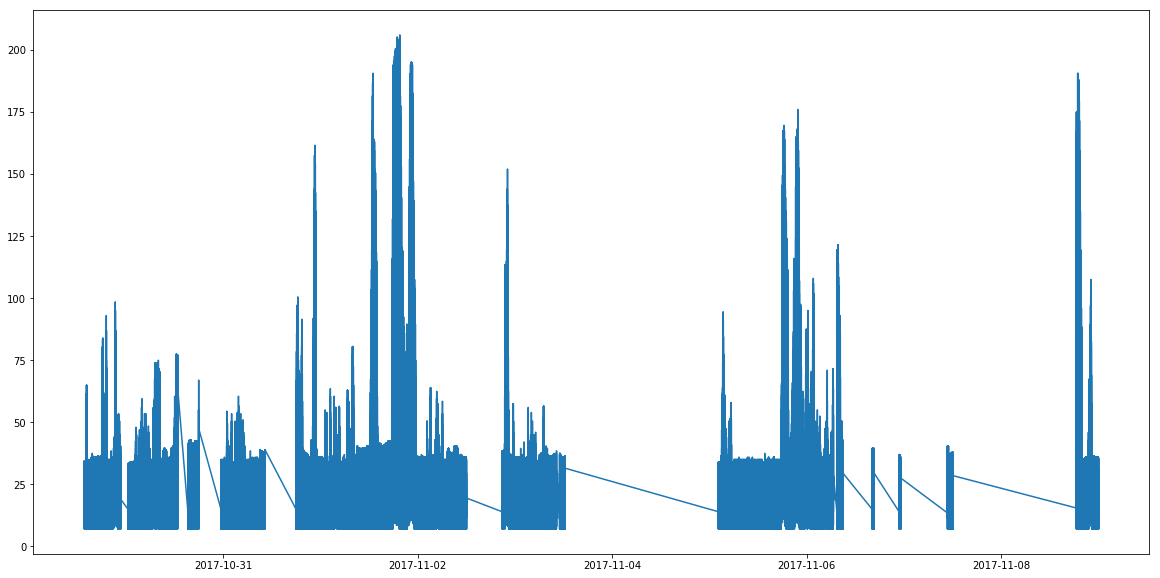

In [58]:
plt.figure(figsize=(20,10))
plt.plot(uberJsonRequests['timestamp'],uberJsonRequests['mean_estimate'])

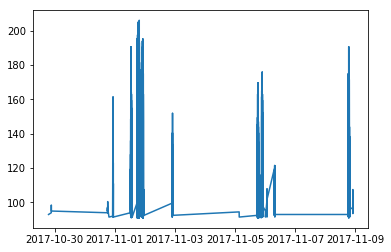

In [60]:
plt.plot(uberJsonRequests[uberJsonRequests['high_estimate']>100]['timestamp'],uberJsonRequests[uberJsonRequests['high_estimate']>100]['mean_estimate'])

Trips

In [68]:
uberJsonRequests[uberJsonRequests['high_estimate']>200]

,id,timestamp,periodOfDay,neighborhood,start_latitude,start_longitude,finish_latitude,finish_longitude,currency_code,distance,duration,high_estimate,low_estimate,product_id,mean_estimate,region
99817,369,2017-11-01 12:52:51.860501,afternoon,Lagoa Azul,-5.8323,-35.2054,-5.734177,-35.253802,BRL,12.07,2160,206.0,167.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,186.5,North
99889,370,2017-11-01 12:55:12.018632,afternoon,Lagoa Azul,-5.8323,-35.2054,-5.734177,-35.253802,BRL,12.07,2160,206.0,167.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,186.5,North
99961,371,2017-11-01 12:57:31.907471,afternoon,Lagoa Azul,-5.8323,-35.2054,-5.734177,-35.253802,BRL,12.07,2160,210.0,171.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,190.5,North
100033,372,2017-11-01 12:59:52.505610,afternoon,Lagoa Azul,-5.8323,-35.2054,-5.734177,-35.253802,BRL,12.07,2160,210.0,171.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,190.5,North
100105,373,2017-11-01 13:02:15.151039,afternoon,Lagoa Azul,-5.8323,-35.2054,-5.734177,-35.253802,BRL,12.07,2160,204.0,166.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,185.0,North
108961,496,2017-11-01 17:57:05.452988,afternoon,Lagoa Azul,-5.8323,-35.2054,-5.734177,-35.253802,BRL,11.72,2580,209.0,170.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,189.5,North
109033,497,2017-11-01 17:59:30.426915,afternoon,Lagoa Azul,-5.8323,-35.2054,-5.734177,-35.253802,BRL,11.72,2580,214.0,174.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,194.0,North
109105,498,2017-11-01 18:02:13.694415,evening,Lagoa Azul,-5.8323,-35.2054,-5.734177,-35.253802,BRL,11.04,2580,213.0,174.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,193.5,North
109177,499,2017-11-01 18:04:53.295493,evening,Lagoa Azul,-5.8323,-35.2054,-5.734177,-35.253802,BRL,11.72,2700,216.0,175.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,195.5,North
109249,500,2017-11-01 18:07:26.490731,evening,Lagoa Azul,-5.8323,-35.2054,-5.734177,-35.253802,BRL,11.72,2700,215.0,175.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,195.0,North


## Choropleth
<hr>

After adjusting our data we now are prepared to prepare for our Choropleth.

### Color map and Threshold
<hr>

As we noticed we could make a set of values baxed on Uber products, Uber X and Uber Select, and another data based on the period of time, morning/afternoon/evening. For each Uber product or period of time we could use a colormap to see how the trips are distributed in terms of price.

In [10]:
colormap = linear.GnBu.scale(uberJsonRequests['low_estimate'].mean(), uberJsonRequests['high_estimate'].mean())
colormap

##### Uber Products

In [39]:
colorscaleUberX = linear.BuPu.scale(uberProducts['65cb1829-9761-40f8-acc6-92d700fe2924'].min(), uberProducts['65cb1829-9761-40f8-acc6-92d700fe2924'].max())
colorscaleUberX

In [40]:
colorscaleUberSelect = linear.BuPu.scale(uberProducts['bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138'].min(), uberProducts['bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138'].max())
colorscaleUberSelect

##### Period of day

In [50]:
colorscaleMorning = linear.BuGn.scale(uberPeriodOfDay['morning'].min(), uberPeriodOfDay['morning'].max())
colorscaleMorning

In [51]:
colorscaleAfternoon = linear.OrRd.scale(uberPeriodOfDay['afternoon'].min(), uberPeriodOfDay['afternoon'].max())
colorscaleAfternoon

In [52]:
colorscaleEvening = linear.PuBu.scale(uberPeriodOfDay['evening'].min(), uberPeriodOfDay['evening'].max())
colorscaleEvening

Observe the different bounds of the period of day. The high estimate in the period of evening (that goes from 6PM to 6AM) is about 
<strong><h1><center><font color='red'>61.86%</font></center></h1></strong> 
more expensive than the period of morning (6AM to noon). 
$$ \big({\dfrac{Max_{Morning}}{Max_{Evening}}}\big)*100 $$

In [46]:
# Create a map object
uberMap = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=12,
    tiles='cartodbpositron', 
    height=800
)

# UberX
folium.GeoJson(
    geo_json_natal,
    name='UberX Price Estimates',
    style_function=lambda feature: {
        'fillColor': colorscaleUberX(uberProducts['65cb1829-9761-40f8-acc6-92d700fe2924'][feature['properties']['name']]),
        'color': 'blue',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0.8,
        'name': feature['properties']['name']
    }
).add_to(uberMap)

# UberSelect
folium.GeoJson(
    geo_json_natal,
    name='UberSelect Price Estimates',
    style_function=lambda feature: {
        'fillColor': colorscaleUberSelect(uberProducts['bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138'][feature['properties']['name']]),
        'color': 'blue',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0.8,
        'name': feature['properties']['name']
    }
).add_to(uberMap)

colorscaleUberX.caption = 'UberX Price Estimatives'
colorscaleUberX.add_to(uberMap)
colorscaleUberSelect.caption = 'UberSelect Price Estimatives'
colorscaleUberSelect.add_to(uberMap)

folium.LayerControl().add_to(uberMap)

uberMap

In [54]:
# Create a map object
uberMapPeriod = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=12,
    tiles='cartodbpositron'
)

# Morning
folium.GeoJson(
    geo_json_natal,
    name='Morning Price Estimates',
    style_function=lambda feature: {
        'fillColor': colorscaleMorning(uberPeriodOfDay['morning'][feature['properties']['name']]),
        'color': 'green',
        'weight': 0.5,
        'dashArray': '1,1',
        'fillOpacity': 0.8,
        'name': feature['properties']['name']
    }
).add_to(uberMapPeriod)

# Afternoon
folium.GeoJson(
    geo_json_natal,
    name='Afternoon Price Estimates',
    style_function=lambda feature: {
        'fillColor': colorscaleAfternoon(uberPeriodOfDay['afternoon'][feature['properties']['name']]),
        'color': 'orange',
        'weight': 0.5,
        'dashArray': '1, 1',
        'fillOpacity': 0.8,
        'name': feature['properties']['name']
    }
).add_to(uberMapPeriod)

# Evening
folium.GeoJson(
    geo_json_natal,
    name='Afternoon Price Estimates',
    style_function=lambda feature: {
        'fillColor': colorscaleEvening(uberPeriodOfDay['evening'][feature['properties']['name']]),
        'color': 'black',
        'weight': 0.5,
        'dashArray': '1, 1',
        'fillOpacity': 0.8,
        'name': feature['properties']['name']
    }
).add_to(uberMapPeriod)

colorscaleMorning.caption = 'Morning Price Estimatives'
colorscaleMorning.add_to(uberMapPeriod)

colorscaleAfternoon.caption = 'Afternoon Price Estimatives'
colorscaleAfternoon.add_to(uberMapPeriod)

colorscaleEvening.caption = 'Evening Price Estimatives'
colorscaleEvening.add_to(uberMapPeriod)

folium.LayerControl().add_to(uberMapPeriod)

uberMapPeriod

In [74]:
# Create a map object
uberMapGeneral = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=12,
    tiles='cartodbpositron', 
    height=800
)


folium.GeoJson(
    geo_json_natal,
    name='UberX Price Estimates',
    style_function=lambda feature: {
        'fillColor': colormap(uberNeigh[feature['properties']['name']]),
        'color': 'white',
        'weight': 0.5,
        'dashArray': '1, 1',
        'fillOpacity': 0.8,
        'name': feature['properties']['name']
    }
).add_to(uberMapGeneral)

colormap.caption = 'General Price Estimatives'
colormap.add_to(uberMapGeneral)

folium.LayerControl().add_to(uberMapGeneral)

for destinationPoint in uberNeigh:
    folium.Marker()
folium.Marker([-5.796158, -35.216566], popup='Alecrim, Valor médio: 21.177857').add_to(uberMapGeneral)
folium.Marker([-5.789477, -35.188454], popup='Areia Preta, Valor médio: 23.977857').add_to(uberMapGeneral)
folium.Marker([-5.800741, -35.211056], popup='Barro Vermelho, Valor médio: 18.666429').add_to(uberMapGeneral)
folium.Marker([-5.813764, -35.240721], popup='Bom Pastor, Valor médio: 19.228393').add_to(uberMapGeneral)
folium.Marker([-5.841737, -35.210463], popup='Candelária, Valor médio: 11.591687').add_to(uberMapGeneral)
folium.Marker([-5.862753, -35.195597], popup='Capim Macio, Valor médio: 16.732264').add_to(uberMapGeneral)
folium.Marker([-5.785291, -35.206464], popup='Cidade Alta, Valor médio: 23.384464').add_to(uberMapGeneral)
folium.Marker([-5.825376, -35.242751], popup='Cidade da Esperança, Valor médio: 23.109185').add_to(uberMapGeneral)
folium.Marker([-5.834856, -35.242523], popup='Cidade Nova, Valor médio: 20.746426').add_to(uberMapGeneral)
folium.Marker([-5.812036, -35.223915], popup='Dix-Sept Rosado, Valor médio: 16.956429').add_to(uberMapGeneral)
folium.Marker([-5.824374, -35.250070], popup='Felipe Camarão, Valor médio: 23.978914').add_to(uberMapGeneral)
folium.Marker([-5.841580, -35.274691], popup='Guarapes, Valor médio: 36.411187').add_to(uberMapGeneral)
folium.Marker([-5.769009, -35.254755], popup='Igapó, Valor médio: 33.120807').add_to(uberMapGeneral)
folium.Marker([-5.734177, -35.253802], popup='Lagoa Azul, Valor médio: 45.140514').add_to(uberMapGeneral)
folium.Marker([-5.819743, -35.212920], popup='Lagoa Nova, Valor médio: 12.775357').add_to(uberMapGeneral)
folium.Marker([-5.809191, -35.209374], popup='Lagoa Seca, Valor médio: 15.975205').add_to(uberMapGeneral)
folium.Marker([-5.794771, -35.188619], popup='Mãe Luiza, Valor médio: 23.746786').add_to(uberMapGeneral)
folium.Marker([-5.870513, -35.208176], popup='Neópolis, Valor médio: 19.888275').add_to(uberMapGeneral)
folium.Marker([-5.796215, -35.245141], popup='Nordeste, Valor médio: 27.215000').add_to(uberMapGeneral)
folium.Marker([-5.763654, -35.282543], popup='Nossa Senhora da Apresentação, Valor médio: 38.594575').add_to(uberMapGeneral)
folium.Marker([-5.815939, -35.229249], popup='Nossa Senhora de Nazaré, Valor médio: 16.518571').add_to(uberMapGeneral)
folium.Marker([-5.824830, -35.200026], popup='Nova Descoberta, Valor médio: 9.996964').add_to(uberMapGeneral)
folium.Marker([-5.751781, -35.234665], popup='Pajuçara, Valor médio: 39.676061').add_to(uberMapGeneral)
folium.Marker([-5.782001, -35.195196], popup='Petrópolis, Valor médio: 23.243929').add_to(uberMapGeneral)
folium.Marker([-5.876271, -35.224500], popup='Pitimbu, Valor médio: 21.161262').add_to(uberMapGeneral)
folium.Marker([-5.858102, -35.251586], popup='Planalto, Valor médio: 28.573770').add_to(uberMapGeneral)
folium.Marker([-5.877522, -35.176073], popup='Ponta Negra, Valor médio: 21.856557').add_to(uberMapGeneral)
folium.Marker([-5.758634, -35.247010], popup='Potengi, Valor médio: 37.519636').add_to(uberMapGeneral)
folium.Marker([-5.779198, -35.197163], popup='Praia do Meio, Valor médio: 23.750624').add_to(uberMapGeneral)
folium.Marker([-5.797290, -35.226006], popup='Quintas, Valor médio: 22.788750').add_to(uberMapGeneral)
folium.Marker([-5.742772, -35.205806], popup='Redinha, Valor médio: 35.059579').add_to(uberMapGeneral)
folium.Marker([-5.774943, -35.205578], popup='Ribeira, Valor médio: 26.279643').add_to(uberMapGeneral)
folium.Marker([-5.771832, -35.203091], popup='Rocas, Valor médio: 26.428826').add_to(uberMapGeneral)
folium.Marker([-5.763117, -35.247973], popup='Salinas, Valor médio: 37.037460').add_to(uberMapGeneral)
folium.Marker([-5.763226, -35.196786], popup='Santos Reis, Valor médio: 27.564395').add_to(uberMapGeneral)
folium.Marker([-5.791699, -35.197358], popup='Tirol, Valor médio: 22.539286').add_to(uberMapGeneral)

uberMapGeneral